In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

In [2]:
#set training device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#batch size for training set
batch_size=128

#load dataset
mnist = datasets.MNIST('./MNIST_data', train=True, download=True,transform=transforms.ToTensor())

#Iterate dataset useing dataloader
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)

In [3]:
# Defining functions to use for training the data
import torch
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def show_images(images, color=False):
    if color:
        sqrtimg = int(np.ceil(np.sqrt(images.shape[2]*images.shape[3])))
    else:
        images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
        sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))


    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        if color:
            plt.imshow(np.swapaxes(np.swapaxes(img, 0, 1), 1, 2))
        else:
            plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def sample_noise(batch_size, dim):
    return torch.randn(batch_size, dim)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, d_dim=8):
        super().__init__()
        self.conv1 = nn.Conv2d(1, d_dim, kernel_size=4, stride=2, padding=1, bias=False)
        
        self.conv2 = nn.Conv2d(d_dim, d_dim*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch2 = nn.BatchNorm2d(d_dim*2)
        
        self.conv3 = nn.Conv2d(d_dim*2, d_dim*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch3 = nn.BatchNorm2d(d_dim*4)
                
        self.linear = nn.Linear(288,1)
        
        self.d_dim = d_dim
        self.sigmoid = nn.Sigmoid()
        self.activation = nn.LeakyReLU(0.2, inplace=True)
        
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.batch2(self.conv2(x)))
        x = self.activation(self.batch3(self.conv3(x)))
        x = x.view(128, -1)
        x = self.linear(x)
        return self.sigmoid(x)

In [5]:
class Generator(nn.Module):
    def __init__(self, noise_dim=75, g_dim=16):
        super().__init__()     
        self.linear = nn.Linear(noise_dim, 7*7*g_dim*4)
        
        self.ct1 = nn.ConvTranspose2d(g_dim*4, g_dim*2, 4, stride=2)
        self.batch1 = nn.BatchNorm2d(g_dim*2)
        
        self.ct2 = nn.ConvTranspose2d(g_dim*2, g_dim, 4, stride=2)
        self.batch2 = nn.BatchNorm2d(g_dim)
        
        self.conv = nn.Conv2d(g_dim, 1, kernel_size=7)
        
        self.activation = nn.ReLU(True)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.activation(self.linear(x))
        x = x.view(-1, 64, 7, 7)
        x = self.activation(self.batch1(self.ct1(x)))
        x = self.activation(self.batch2(self.ct2(x)))
        x = self.conv(x)
        return self.tanh(x)
         

In [6]:
def training_loop(discriminator, generator, d_optimizer, g_optimizer, d_loss, g_loss, show_every=250, batch_size=128, noise_size=75,
                                                                n_epochs=50, train_loader=None, device=None):
    iter_count = 0
    
    for epoch in range(1, n_epochs+1):
        print("Epoch %d\n" % (epoch))
        for x, _ in train_loader:

            _, input_channels, img_size, _ = x.shape
            
            real_images = preprocess_img(x).to(device)

            d_error = None
            g_error = None
            fake_images = None

            # Updating Discriminator
            d_optimizer.zero_grad()
            logits_real = discriminator(real_images)
            real_label = torch.ones_like(logits_real, dtype=torch.float, device=device)*0.9
            errD_real = discriminator_loss(logits_real, real_label)
            
            fake_seed = sample_noise(batch_size, noise_size).to(device)
            fake_images = generator(fake_seed)
            logits_fake = discriminator(fake_images.detach())
            fake_label = torch.ones_like(logits_fake, dtype=torch.float, device=device)*0.1
            errD_fake = discriminator_loss(logits_fake, fake_label)
            
            d_error = errD_real + errD_fake
            d_error.backward()
            d_optimizer.step()

            # Updating Generator
            g_optimizer.zero_grad()
            fake_logits = discriminator(fake_images)
            real_label = torch.ones_like(fake_logits, dtype=torch.float, device=device)
            g_error = generator_loss(fake_logits, real_label)
            g_error.backward()
            g_optimizer.step()
            
            # Logging and output visualization
            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_error.item(),g_error.item()))
                disp_fake_images = deprocess_img(fake_images.data)  # denormalize
                imgs_numpy = (disp_fake_images).cpu().numpy()
                show_images(imgs_numpy[0:16], color=input_channels!=1)
                plt.show()
                print()

            iter_count += 1

Epoch 1

Iter: 0, D: 1.462, G:0.4796


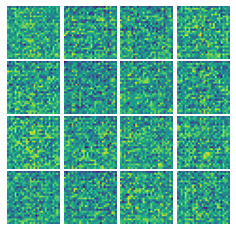


Iter: 250, D: 1.382, G:0.6273


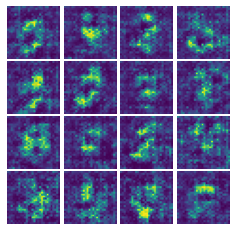


Epoch 2

Iter: 500, D: 1.379, G:0.6377


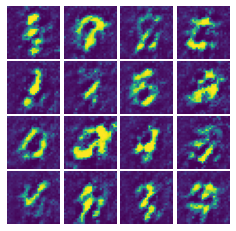


Iter: 750, D: 1.379, G:0.6393


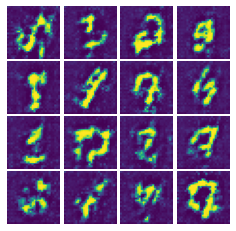


Epoch 3

Iter: 1000, D: 1.369, G:0.6261


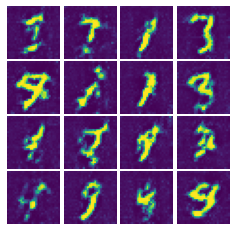


Iter: 1250, D: 1.36, G:0.6274


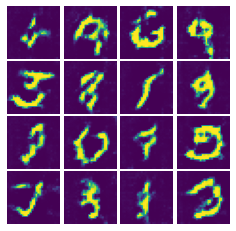


Epoch 4

Iter: 1500, D: 1.371, G:0.6422


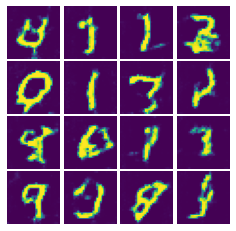


Iter: 1750, D: 1.349, G:0.6343


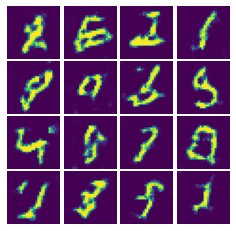


Epoch 5

Iter: 2000, D: 1.343, G:0.6291


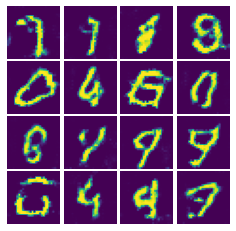


Iter: 2250, D: 1.343, G:0.6545


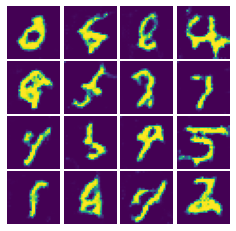


Epoch 6

Iter: 2500, D: 1.362, G:0.6474


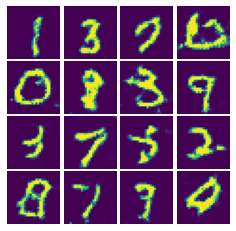


Iter: 2750, D: 1.346, G:0.6271


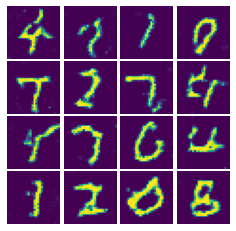


Epoch 7

Iter: 3000, D: 1.354, G:0.6355


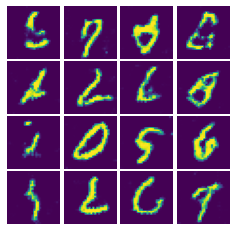


Iter: 3250, D: 1.357, G:0.659


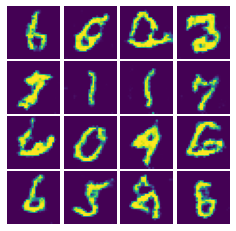


Epoch 8

Iter: 3500, D: 1.353, G:0.6082


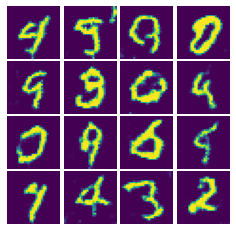


Epoch 9

Iter: 3750, D: 1.306, G:0.6196


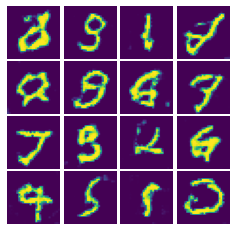


Iter: 4000, D: 1.341, G:0.652


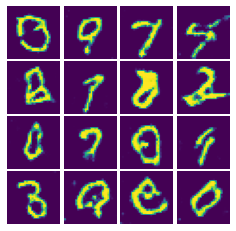


Epoch 10

Iter: 4250, D: 1.333, G:0.6174


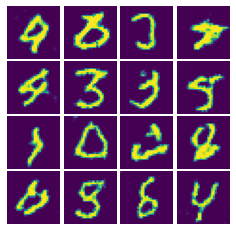


Iter: 4500, D: 1.383, G:0.6383


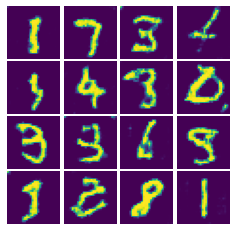


Epoch 11

Iter: 4750, D: 1.342, G:0.6351


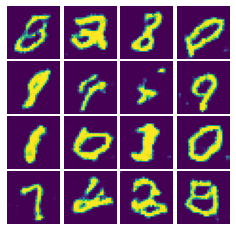


Iter: 5000, D: 1.327, G:0.6345


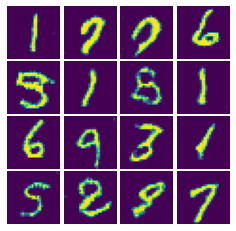


Epoch 12

Iter: 5250, D: 1.325, G:0.6309


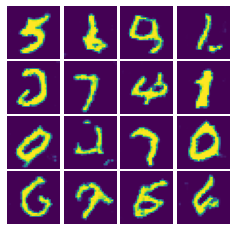


Iter: 5500, D: 1.355, G:0.6455


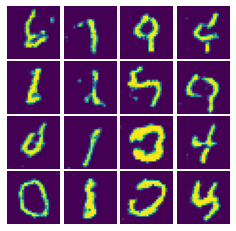


Epoch 13

Iter: 5750, D: 1.36, G:0.6447


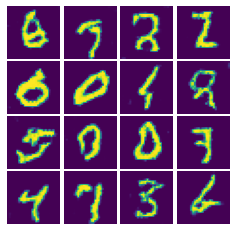


Iter: 6000, D: 1.346, G:0.6434


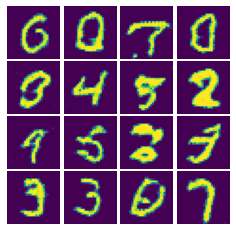


Epoch 14

Iter: 6250, D: 1.345, G:0.6343


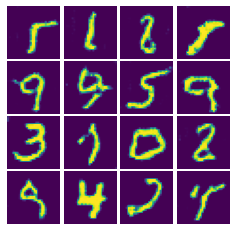


Iter: 6500, D: 1.326, G:0.62


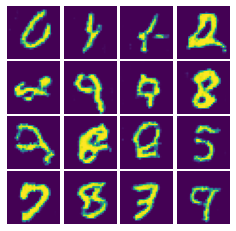


Epoch 15

Iter: 6750, D: 1.33, G:0.6339


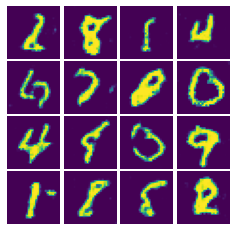


Iter: 7000, D: 1.341, G:0.6298


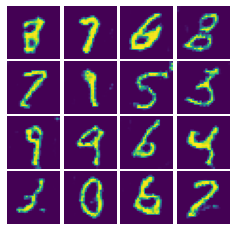


Epoch 16

Iter: 7250, D: 1.342, G:0.6022


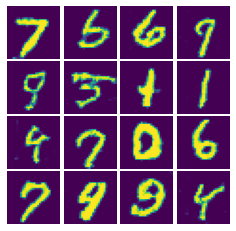


Epoch 17

Iter: 7500, D: 1.334, G:0.6178


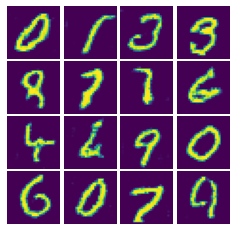


Iter: 7750, D: 1.332, G:0.6378


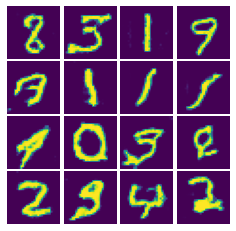


Epoch 18

Iter: 8000, D: 1.356, G:0.6514


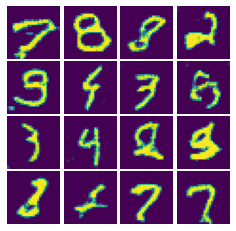


Iter: 8250, D: 1.336, G:0.6386


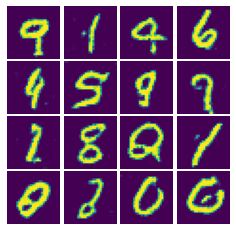


Epoch 19

Iter: 8500, D: 1.316, G:0.6261


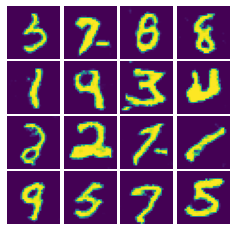


Iter: 8750, D: 1.341, G:0.6241


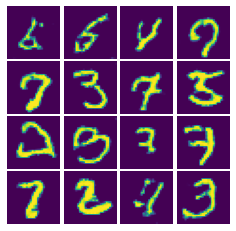


Epoch 20

Iter: 9000, D: 1.326, G:0.6396


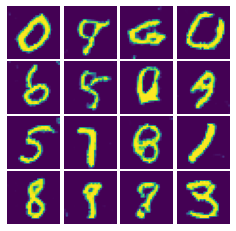


Iter: 9250, D: 1.357, G:0.6307


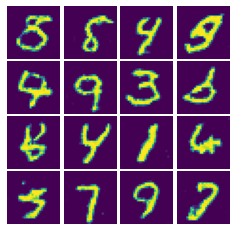


Epoch 21

Iter: 9500, D: 1.36, G:0.6421


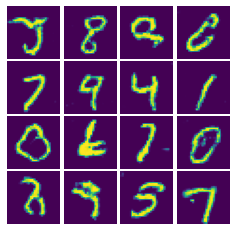


Iter: 9750, D: 1.333, G:0.6125


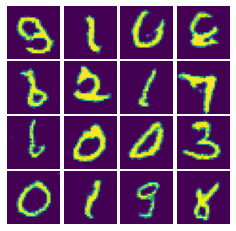


Epoch 22

Iter: 10000, D: 1.303, G:0.6472


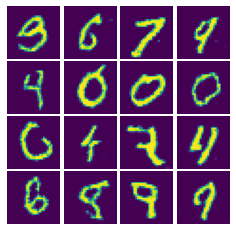


Iter: 10250, D: 1.356, G:0.6548


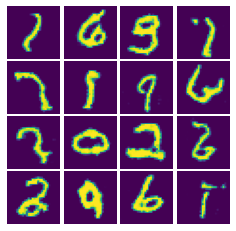


Epoch 23

Iter: 10500, D: 1.356, G:0.6467


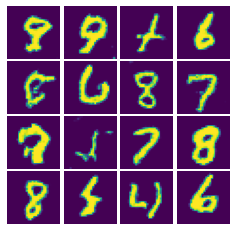


Iter: 10750, D: 1.316, G:0.6452


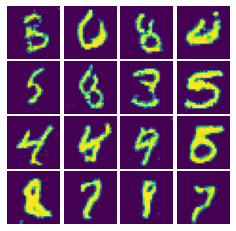


Epoch 24

Iter: 11000, D: 1.36, G:0.6601


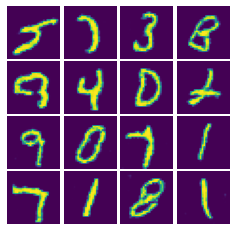


Epoch 25

Iter: 11250, D: 1.312, G:0.6375


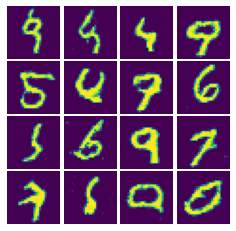


Iter: 11500, D: 1.339, G:0.6219


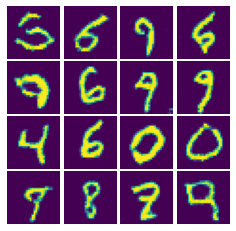


Epoch 26

Iter: 11750, D: 1.352, G:0.6432


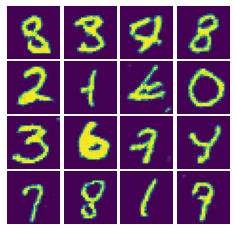


Iter: 12000, D: 1.315, G:0.5969


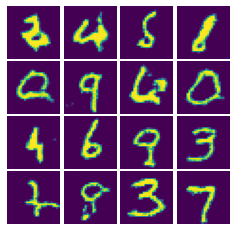


Epoch 27

Iter: 12250, D: 1.366, G:0.6724


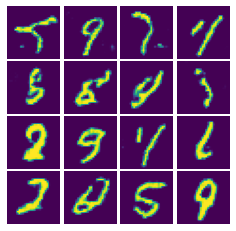


Iter: 12500, D: 1.36, G:0.6432


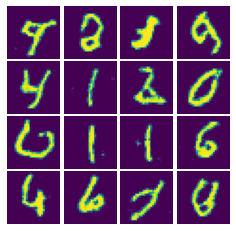


Epoch 28

Iter: 12750, D: 1.298, G:0.6363


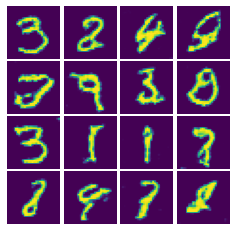


Iter: 13000, D: 1.344, G:0.6424


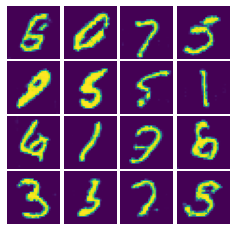


Epoch 29

Iter: 13250, D: 1.336, G:0.6535


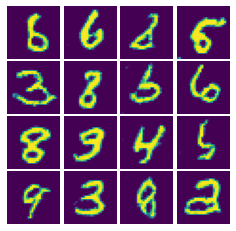


Iter: 13500, D: 1.329, G:0.5936


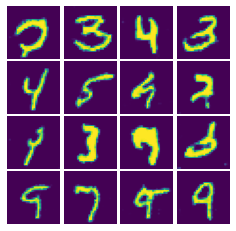


Epoch 30

Iter: 13750, D: 1.337, G:0.6233


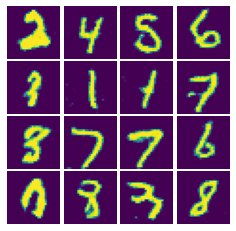


Iter: 14000, D: 1.319, G:0.628


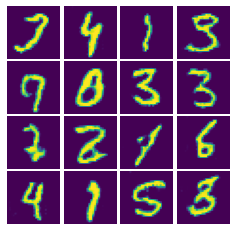


Epoch 31

Iter: 14250, D: 1.341, G:0.6471


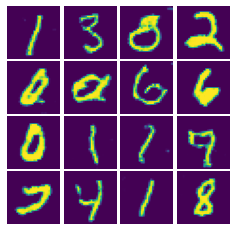


Iter: 14500, D: 1.295, G:0.634


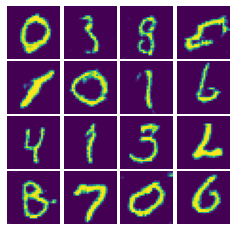


Epoch 32

Iter: 14750, D: 1.334, G:0.6337


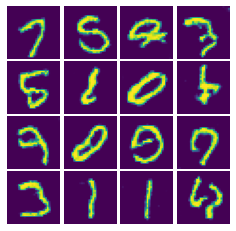


Epoch 33

Iter: 15000, D: 1.31, G:0.6006


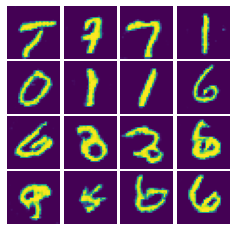


Iter: 15250, D: 1.34, G:0.6538


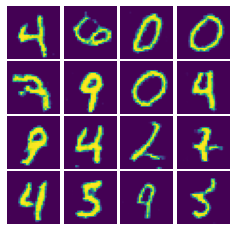


Epoch 34

Iter: 15500, D: 1.319, G:0.6214


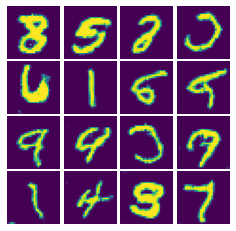


Iter: 15750, D: 1.308, G:0.6392


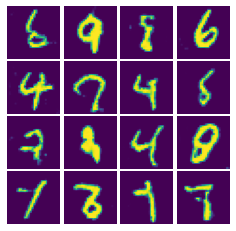


Epoch 35

Iter: 16000, D: 1.354, G:0.6297


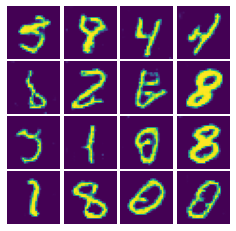


Iter: 16250, D: 1.324, G:0.6328


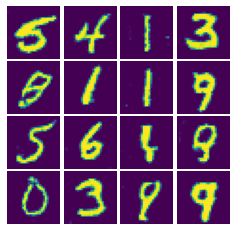


Epoch 36

Iter: 16500, D: 1.351, G:0.6405


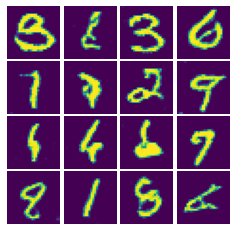


Iter: 16750, D: 1.375, G:0.6581


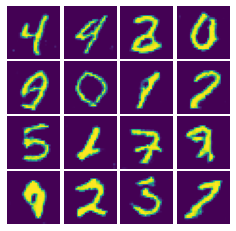


Epoch 37

Iter: 17000, D: 1.339, G:0.6448


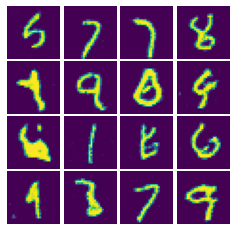


Iter: 17250, D: 1.289, G:0.6258


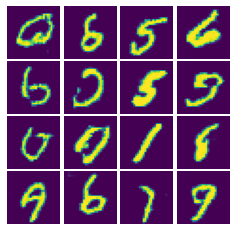


Epoch 38

Iter: 17500, D: 1.354, G:0.6424


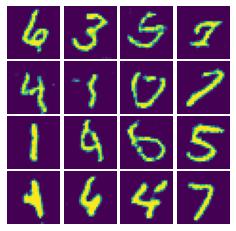


Iter: 17750, D: 1.369, G:0.6538


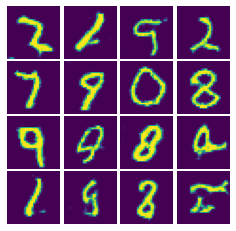


Epoch 39

Iter: 18000, D: 1.34, G:0.6671


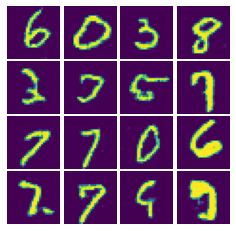


Iter: 18250, D: 1.306, G:0.6081


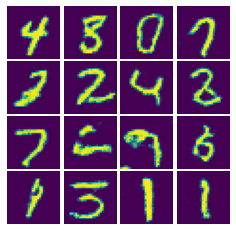


Epoch 40

Iter: 18500, D: 1.334, G:0.6205


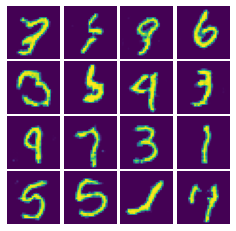


Epoch 41

Iter: 18750, D: 1.371, G:0.6319


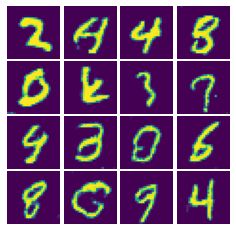


Iter: 19000, D: 1.382, G:0.6734


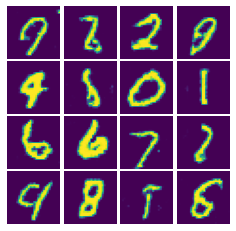


Epoch 42

Iter: 19250, D: 1.363, G:0.621


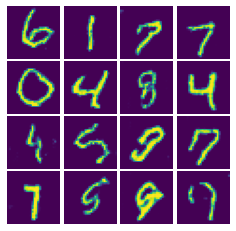


Iter: 19500, D: 1.373, G:0.6353


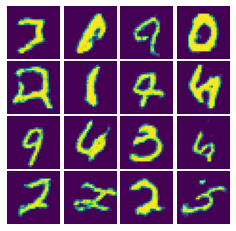


Epoch 43

Iter: 19750, D: 1.361, G:0.6319


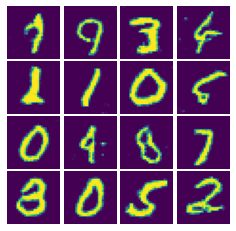


Iter: 20000, D: 1.357, G:0.6737


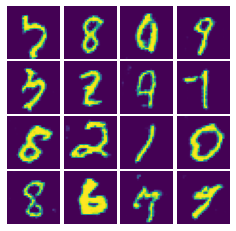


Epoch 44

Iter: 20250, D: 1.386, G:0.6761


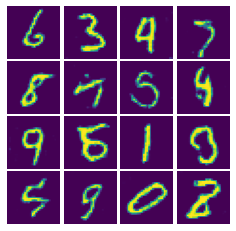


Iter: 20500, D: 1.346, G:0.6531


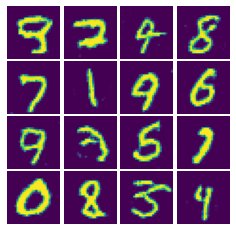


Epoch 45

Iter: 20750, D: 1.377, G:0.6665


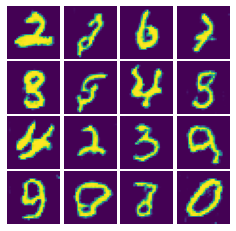


Iter: 21000, D: 1.37, G:0.6637


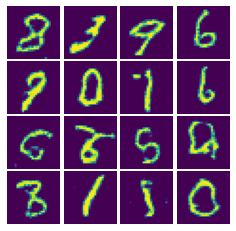


Epoch 46

Iter: 21250, D: 1.344, G:0.6715


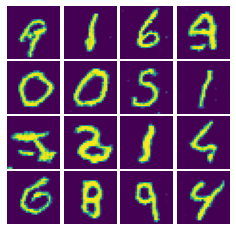


Iter: 21500, D: 1.375, G:0.6489


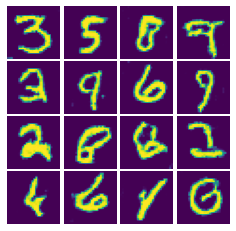


Epoch 47

Iter: 21750, D: 1.371, G:0.6731


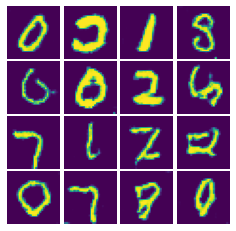


Epoch 48

Iter: 22000, D: 1.308, G:0.6566


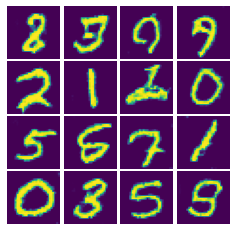


Iter: 22250, D: 1.382, G:0.6517


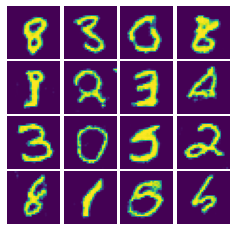


Epoch 49

Iter: 22500, D: 1.365, G:0.6459


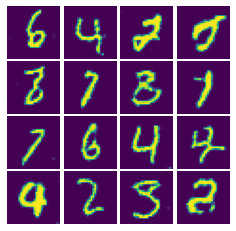


Iter: 22750, D: 1.378, G:0.6748


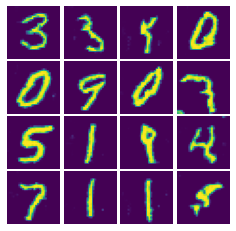


Epoch 50

Iter: 23000, D: 1.371, G:0.6629


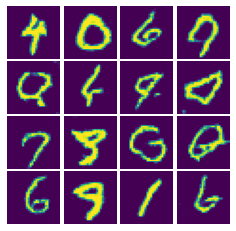


Iter: 23250, D: 1.332, G:0.6212


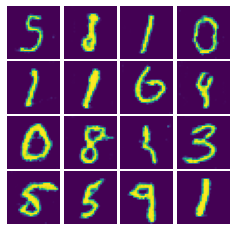


Epoch 51

Iter: 23500, D: 1.373, G:0.6805


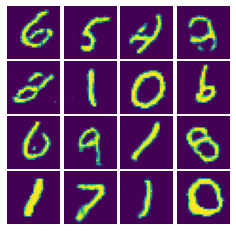


Iter: 23750, D: 1.356, G:0.643


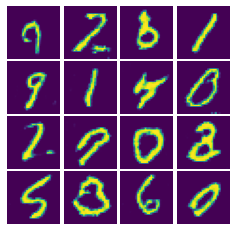


Epoch 52

Iter: 24000, D: 1.372, G:0.6418


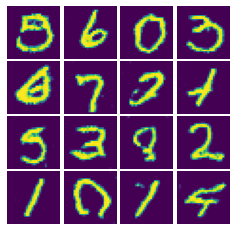


Iter: 24250, D: 1.371, G:0.6605


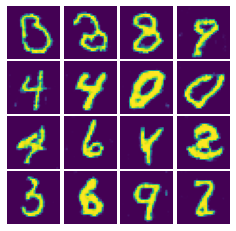


Epoch 53

Iter: 24500, D: 1.359, G:0.6683


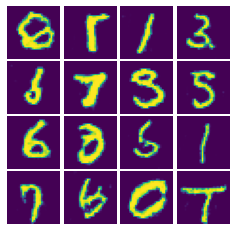


Iter: 24750, D: 1.37, G:0.6589


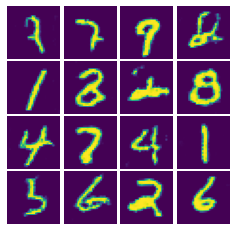


Epoch 54

Iter: 25000, D: 1.345, G:0.6227


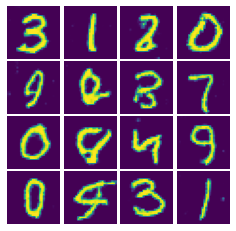


Iter: 25250, D: 1.351, G:0.6454


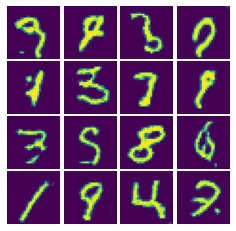


Epoch 55

Iter: 25500, D: 1.357, G:0.6635


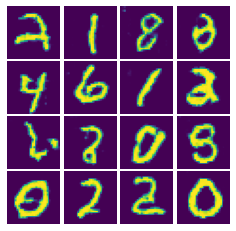


Epoch 56

Iter: 25750, D: 1.39, G:0.6879


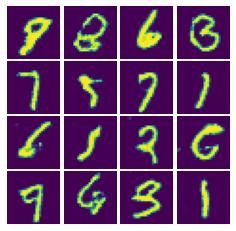


Iter: 26000, D: 1.329, G:0.6503


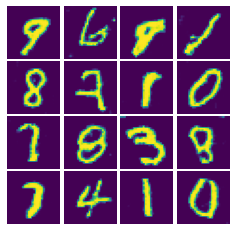


Epoch 57

Iter: 26250, D: 1.339, G:0.6246


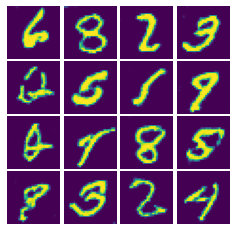


Iter: 26500, D: 1.359, G:0.6506


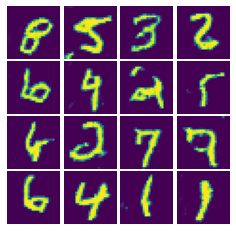


Epoch 58

Iter: 26750, D: 1.309, G:0.6513


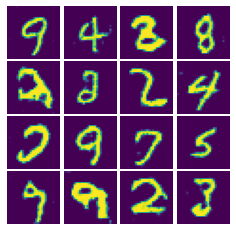


Iter: 27000, D: 1.336, G:0.6645


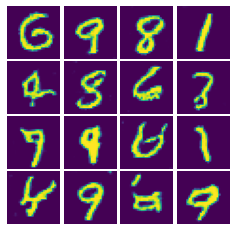


Epoch 59

Iter: 27250, D: 1.384, G:0.6745


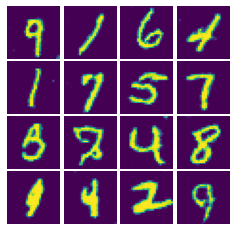


Iter: 27500, D: 1.287, G:0.6295


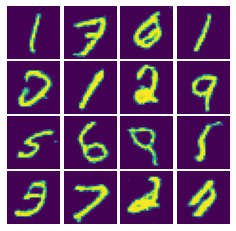


Epoch 60

Iter: 27750, D: 1.36, G:0.6489


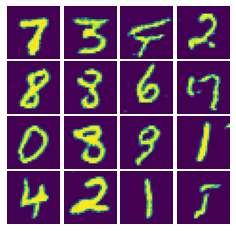


Iter: 28000, D: 1.35, G:0.6347


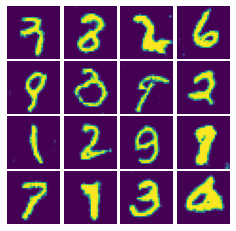


Epoch 61

Iter: 28250, D: 1.373, G:0.6864


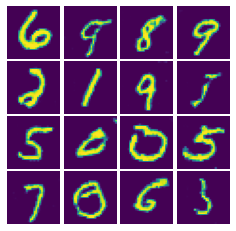


Iter: 28500, D: 1.336, G:0.6545


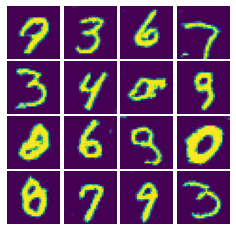


Epoch 62

Iter: 28750, D: 1.3, G:0.6659


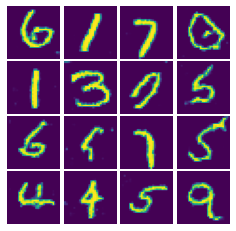


Iter: 29000, D: 1.386, G:0.6723


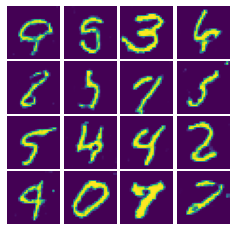


Epoch 63

Iter: 29250, D: 1.298, G:0.6685


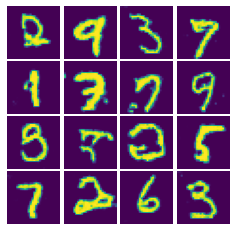


Epoch 64

Iter: 29500, D: 1.385, G:0.6925


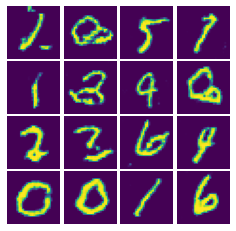


Iter: 29750, D: 1.315, G:0.636


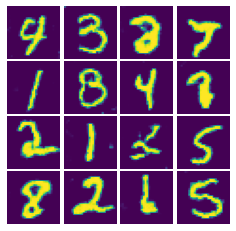


Epoch 65

Iter: 30000, D: 1.358, G:0.637


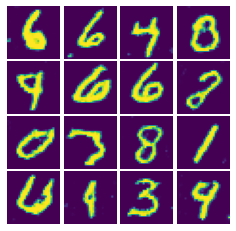


Iter: 30250, D: 1.347, G:0.6399


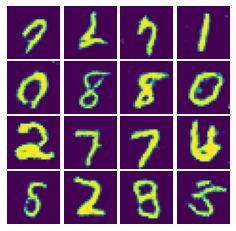


Epoch 66

Iter: 30500, D: 1.366, G:0.6655


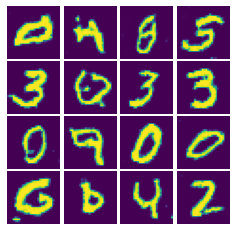


Iter: 30750, D: 1.373, G:0.672


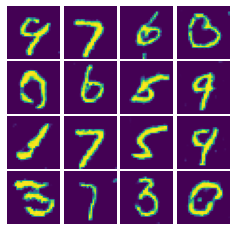


Epoch 67

Iter: 31000, D: 1.382, G:0.6819


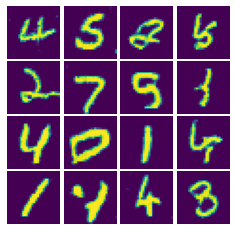


Iter: 31250, D: 1.386, G:0.6919


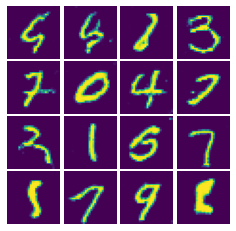


Epoch 68

Iter: 31500, D: 1.318, G:0.649


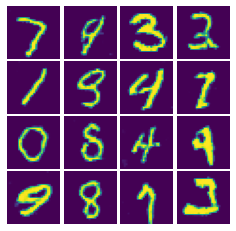


Iter: 31750, D: 1.387, G:0.6601


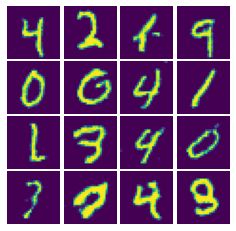


Epoch 69

Iter: 32000, D: 1.387, G:0.6923


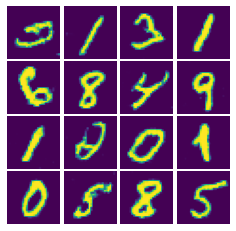


Iter: 32250, D: 1.346, G:0.6332


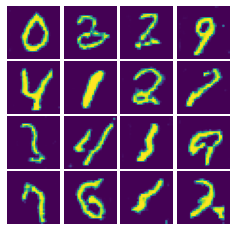


Epoch 70

Iter: 32500, D: 1.334, G:0.616


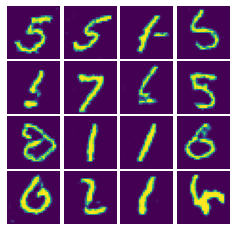


Iter: 32750, D: 1.334, G:0.6018


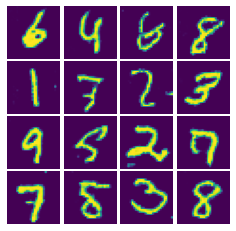


Epoch 71

Iter: 33000, D: 1.361, G:0.6762


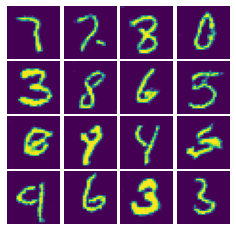


Epoch 72

Iter: 33250, D: 1.39, G:0.6869


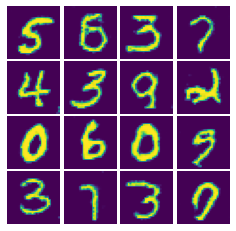


Iter: 33500, D: 1.282, G:0.6617


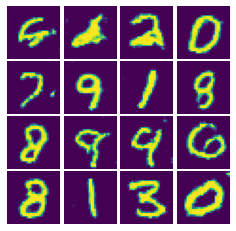


Epoch 73

Iter: 33750, D: 1.362, G:0.6489


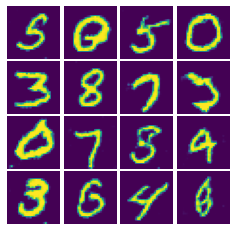


Iter: 34000, D: 1.367, G:0.6469


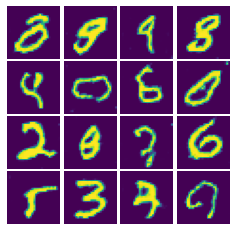


Epoch 74

Iter: 34250, D: 1.386, G:0.6734


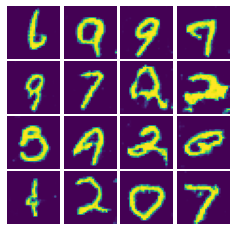


Iter: 34500, D: 1.386, G:0.6666


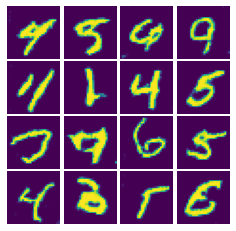


Epoch 75

Iter: 34750, D: 1.386, G:0.6797


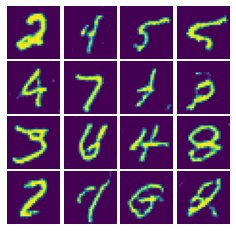


Iter: 35000, D: 1.344, G:0.6288


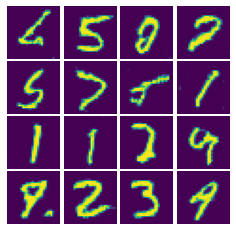


Epoch 76

Iter: 35250, D: 1.39, G:0.6732


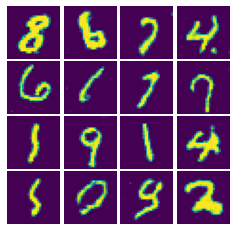


Iter: 35500, D: 1.358, G:0.6692


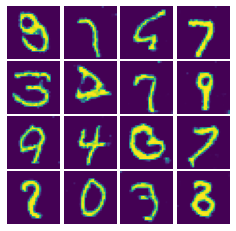


Epoch 77

Iter: 35750, D: 1.318, G:0.6385


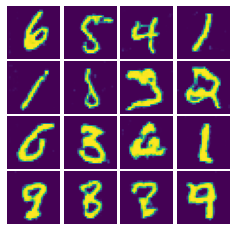


Iter: 36000, D: 1.36, G:0.6286


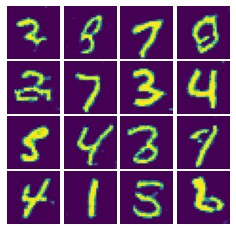


Epoch 78

Iter: 36250, D: 1.358, G:0.6363


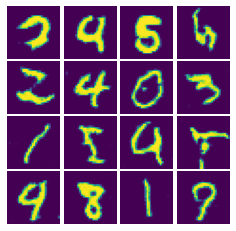


Iter: 36500, D: 1.469, G:0.6495


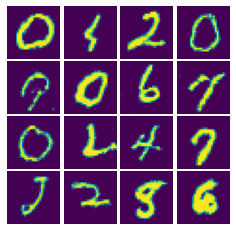


Epoch 79

Iter: 36750, D: 1.322, G:0.6737


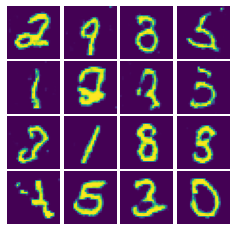


Epoch 80

Iter: 37000, D: 1.371, G:0.674


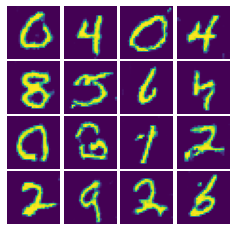


Iter: 37250, D: 1.303, G:0.6615


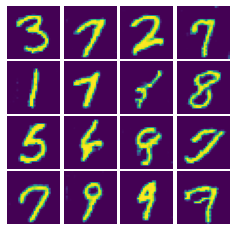


Epoch 81

Iter: 37500, D: 1.359, G:0.6712


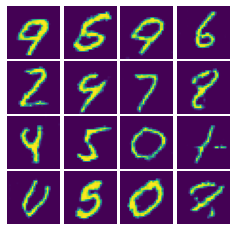


Iter: 37750, D: 1.353, G:0.6457


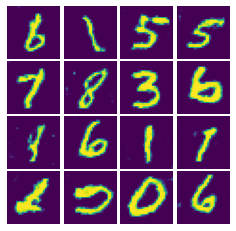


Epoch 82

Iter: 38000, D: 1.382, G:0.6667


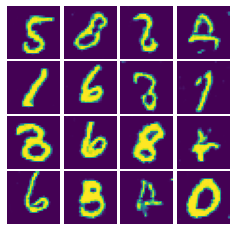


Iter: 38250, D: 1.368, G:0.6568


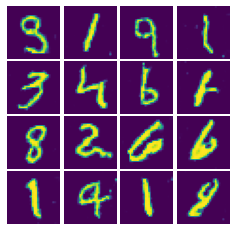


Epoch 83

Iter: 38500, D: 1.402, G:0.6829


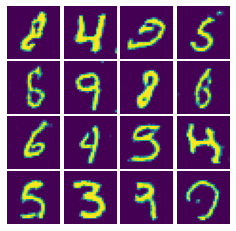


Iter: 38750, D: 1.379, G:0.6678


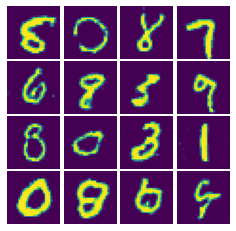


Epoch 84

Iter: 39000, D: 1.24, G:0.6632


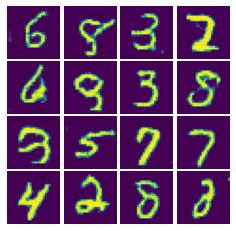


Iter: 39250, D: 1.387, G:0.6869


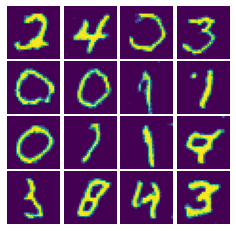


Epoch 85

Iter: 39500, D: 1.408, G:0.6869


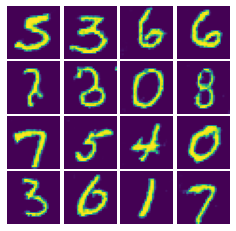


Iter: 39750, D: 1.364, G:0.6625


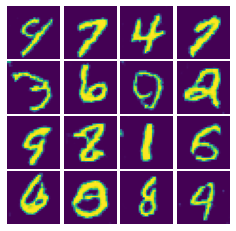


Epoch 86

Iter: 40000, D: 1.366, G:0.6589


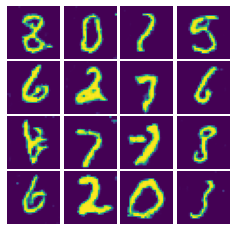


Epoch 87

Iter: 40250, D: 1.419, G:0.6303


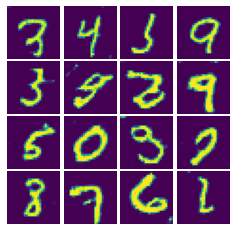


Iter: 40500, D: 1.312, G:0.6848


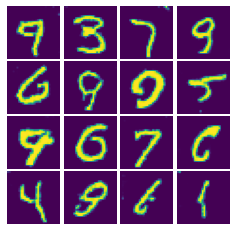


Epoch 88

Iter: 40750, D: 1.34, G:0.654


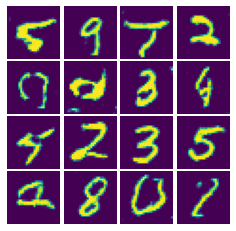


Iter: 41000, D: 1.387, G:0.6919


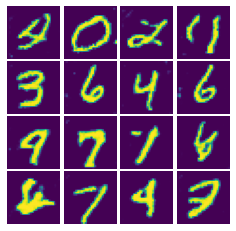


Epoch 89

Iter: 41250, D: 1.338, G:0.6399


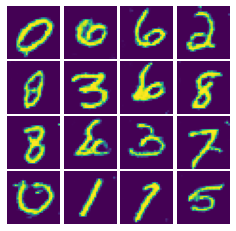


Iter: 41500, D: 1.3, G:0.6511


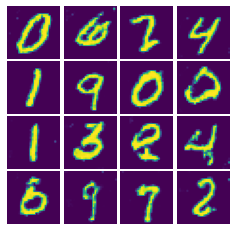


Epoch 90

Iter: 41750, D: 1.383, G:0.6703


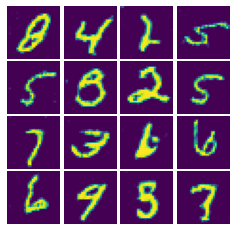


Iter: 42000, D: 1.342, G:0.6672


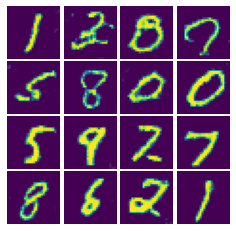


Epoch 91

Iter: 42250, D: 1.371, G:0.6877


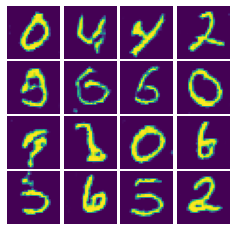


Iter: 42500, D: 1.422, G:0.6802


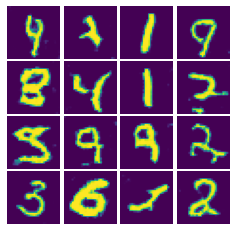


Epoch 92

Iter: 42750, D: 1.36, G:0.6439


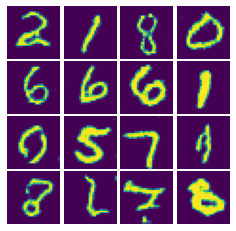


Iter: 43000, D: 1.289, G:0.6769


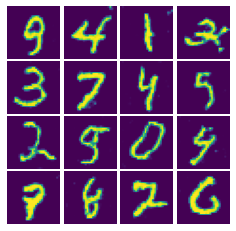


Epoch 93

Iter: 43250, D: 1.365, G:0.664


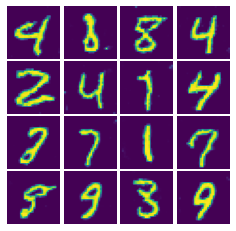


Iter: 43500, D: 1.375, G:0.6897


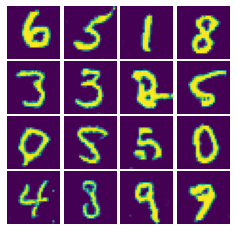


Epoch 94

Iter: 43750, D: 1.316, G:0.6647


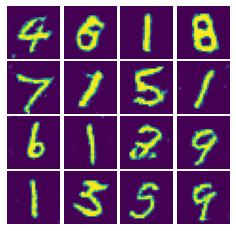


Epoch 95

Iter: 44000, D: 1.391, G:0.6917


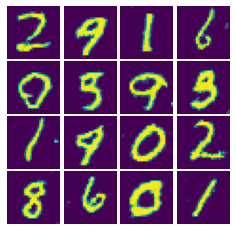


Iter: 44250, D: 1.382, G:0.6923


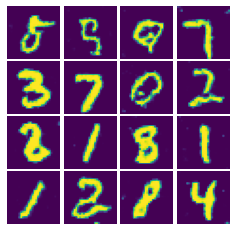


Epoch 96

Iter: 44500, D: 1.38, G:0.6909


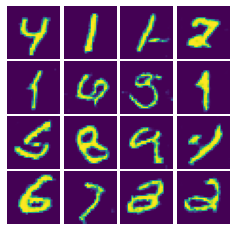


Iter: 44750, D: 1.387, G:0.692


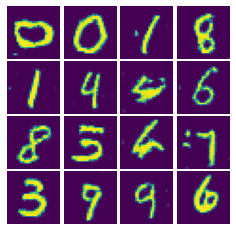


Epoch 97

Iter: 45000, D: 1.339, G:0.6663


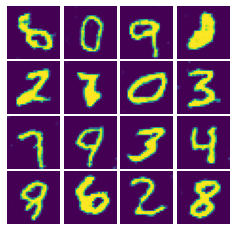


Iter: 45250, D: 1.308, G:0.6513


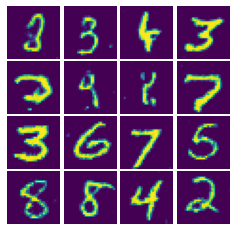


Epoch 98

Iter: 45500, D: 1.345, G:0.6579


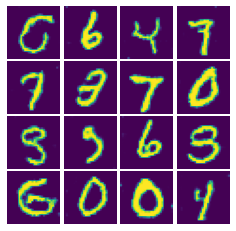


Iter: 45750, D: 1.334, G:0.6696


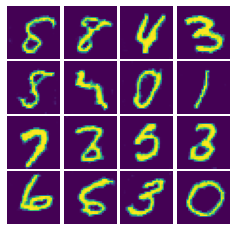


Epoch 99

Iter: 46000, D: 1.334, G:0.6604


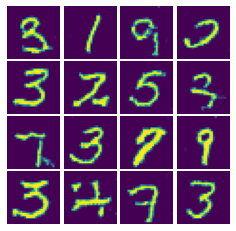


Iter: 46250, D: 1.387, G:0.6924


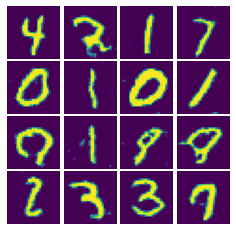


Epoch 100

Iter: 46500, D: 1.388, G:0.6914


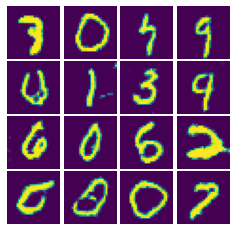


Iter: 46750, D: 1.36, G:0.6605


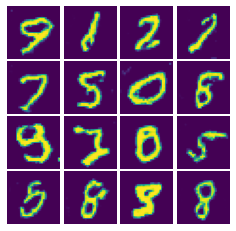

In [7]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0003, betas = (0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0003, betas = (0.5, 0.999))

discriminator_loss = nn.BCEWithLogitsLoss()
generator_loss = nn.BCEWithLogitsLoss()

training_loop(discriminator, generator, d_optimizer, g_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, n_epochs=100, device=device)